In [1]:
import pandas as pd
import numpy as np
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
vars = ['cmpmiss', 'missedE', 'ang_taus', "ang_tau0_pmiss", "ang_tau1_pmiss", 
        "p_tau_0_tagcm", "p_tau_1_tagcm", "theta_Btag", 'tau_d_0_0', 'tau_d_1_0', "N_KL",
        'ang_tau1_ROE', 'ang_tau0_ROE', 'idec0', 'idec1']

In [3]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) & (pc.field("N_KS") < 0.5)
mask_rho_pi = ((pc.field("idec0") == 2) | (pc.field("idec0") == 3)) & ((pc.field("idec1") == 2) | (pc.field("idec1") == 3))
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")

In [4]:
sig = ds.dataset(list(Path(f"new_sig/").glob("*.parquet")), format="parquet")
sig = get_values(sig, vars, filter_mask=mask & mask_rho_pi & mask_is1 & (pc.field("is0") == 1))
lep = ds.dataset(
    [p for i in [1, 2, 3] for p in Path("gen_data/").glob(f"*{i}.parquet")],
    format="parquet",
)
lep = get_values(lep, vars, filter_mask=mask & mask_rho_pi & (pc.field("is0") == 1))

Total data size: 0.47 MB
Total data size: 2.54 MB


In [5]:
lep["label"] = 0  # Класс 0
sig["label"] = 1  # Класс 1
df = pd.concat([sig, lep], ignore_index=True)

In [6]:
X = df.drop(columns=["label"])
y = df["label"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [8]:
w_train = np.where(y_train == 0, 1.0, len(lep) / len(sig))
model = XGBClassifier(
    max_depth=3,
    n_estimators=5000,
    learning_rate=0.02,
    subsample=0.5,
    colsample_bytree=1,
    random_state=42,
)
model.fit(X_train, y_train, sample_weight=w_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93     10165
           1       0.58      0.81      0.68      1872

    accuracy                           0.88     12037
   macro avg       0.77      0.85      0.80     12037
weighted avg       0.90      0.88      0.89     12037

ROC AUC: 0.9338334678656861
Confusion Matrix:
 [[9066 1099]
 [ 347 1525]]


In [10]:
idec0_test = X_test["idec0"].to_numpy()
idec1_test = X_test["idec1"].to_numpy()

mask_pi_pi   = (idec0_test == 2) & (idec1_test == 2)
mask_rho_rho = (idec0_test == 3) & (idec1_test == 3)
mask_pi_rho  = ((idec0_test == 2) & (idec1_test == 3)) | ((idec0_test == 3) & (idec1_test == 2))


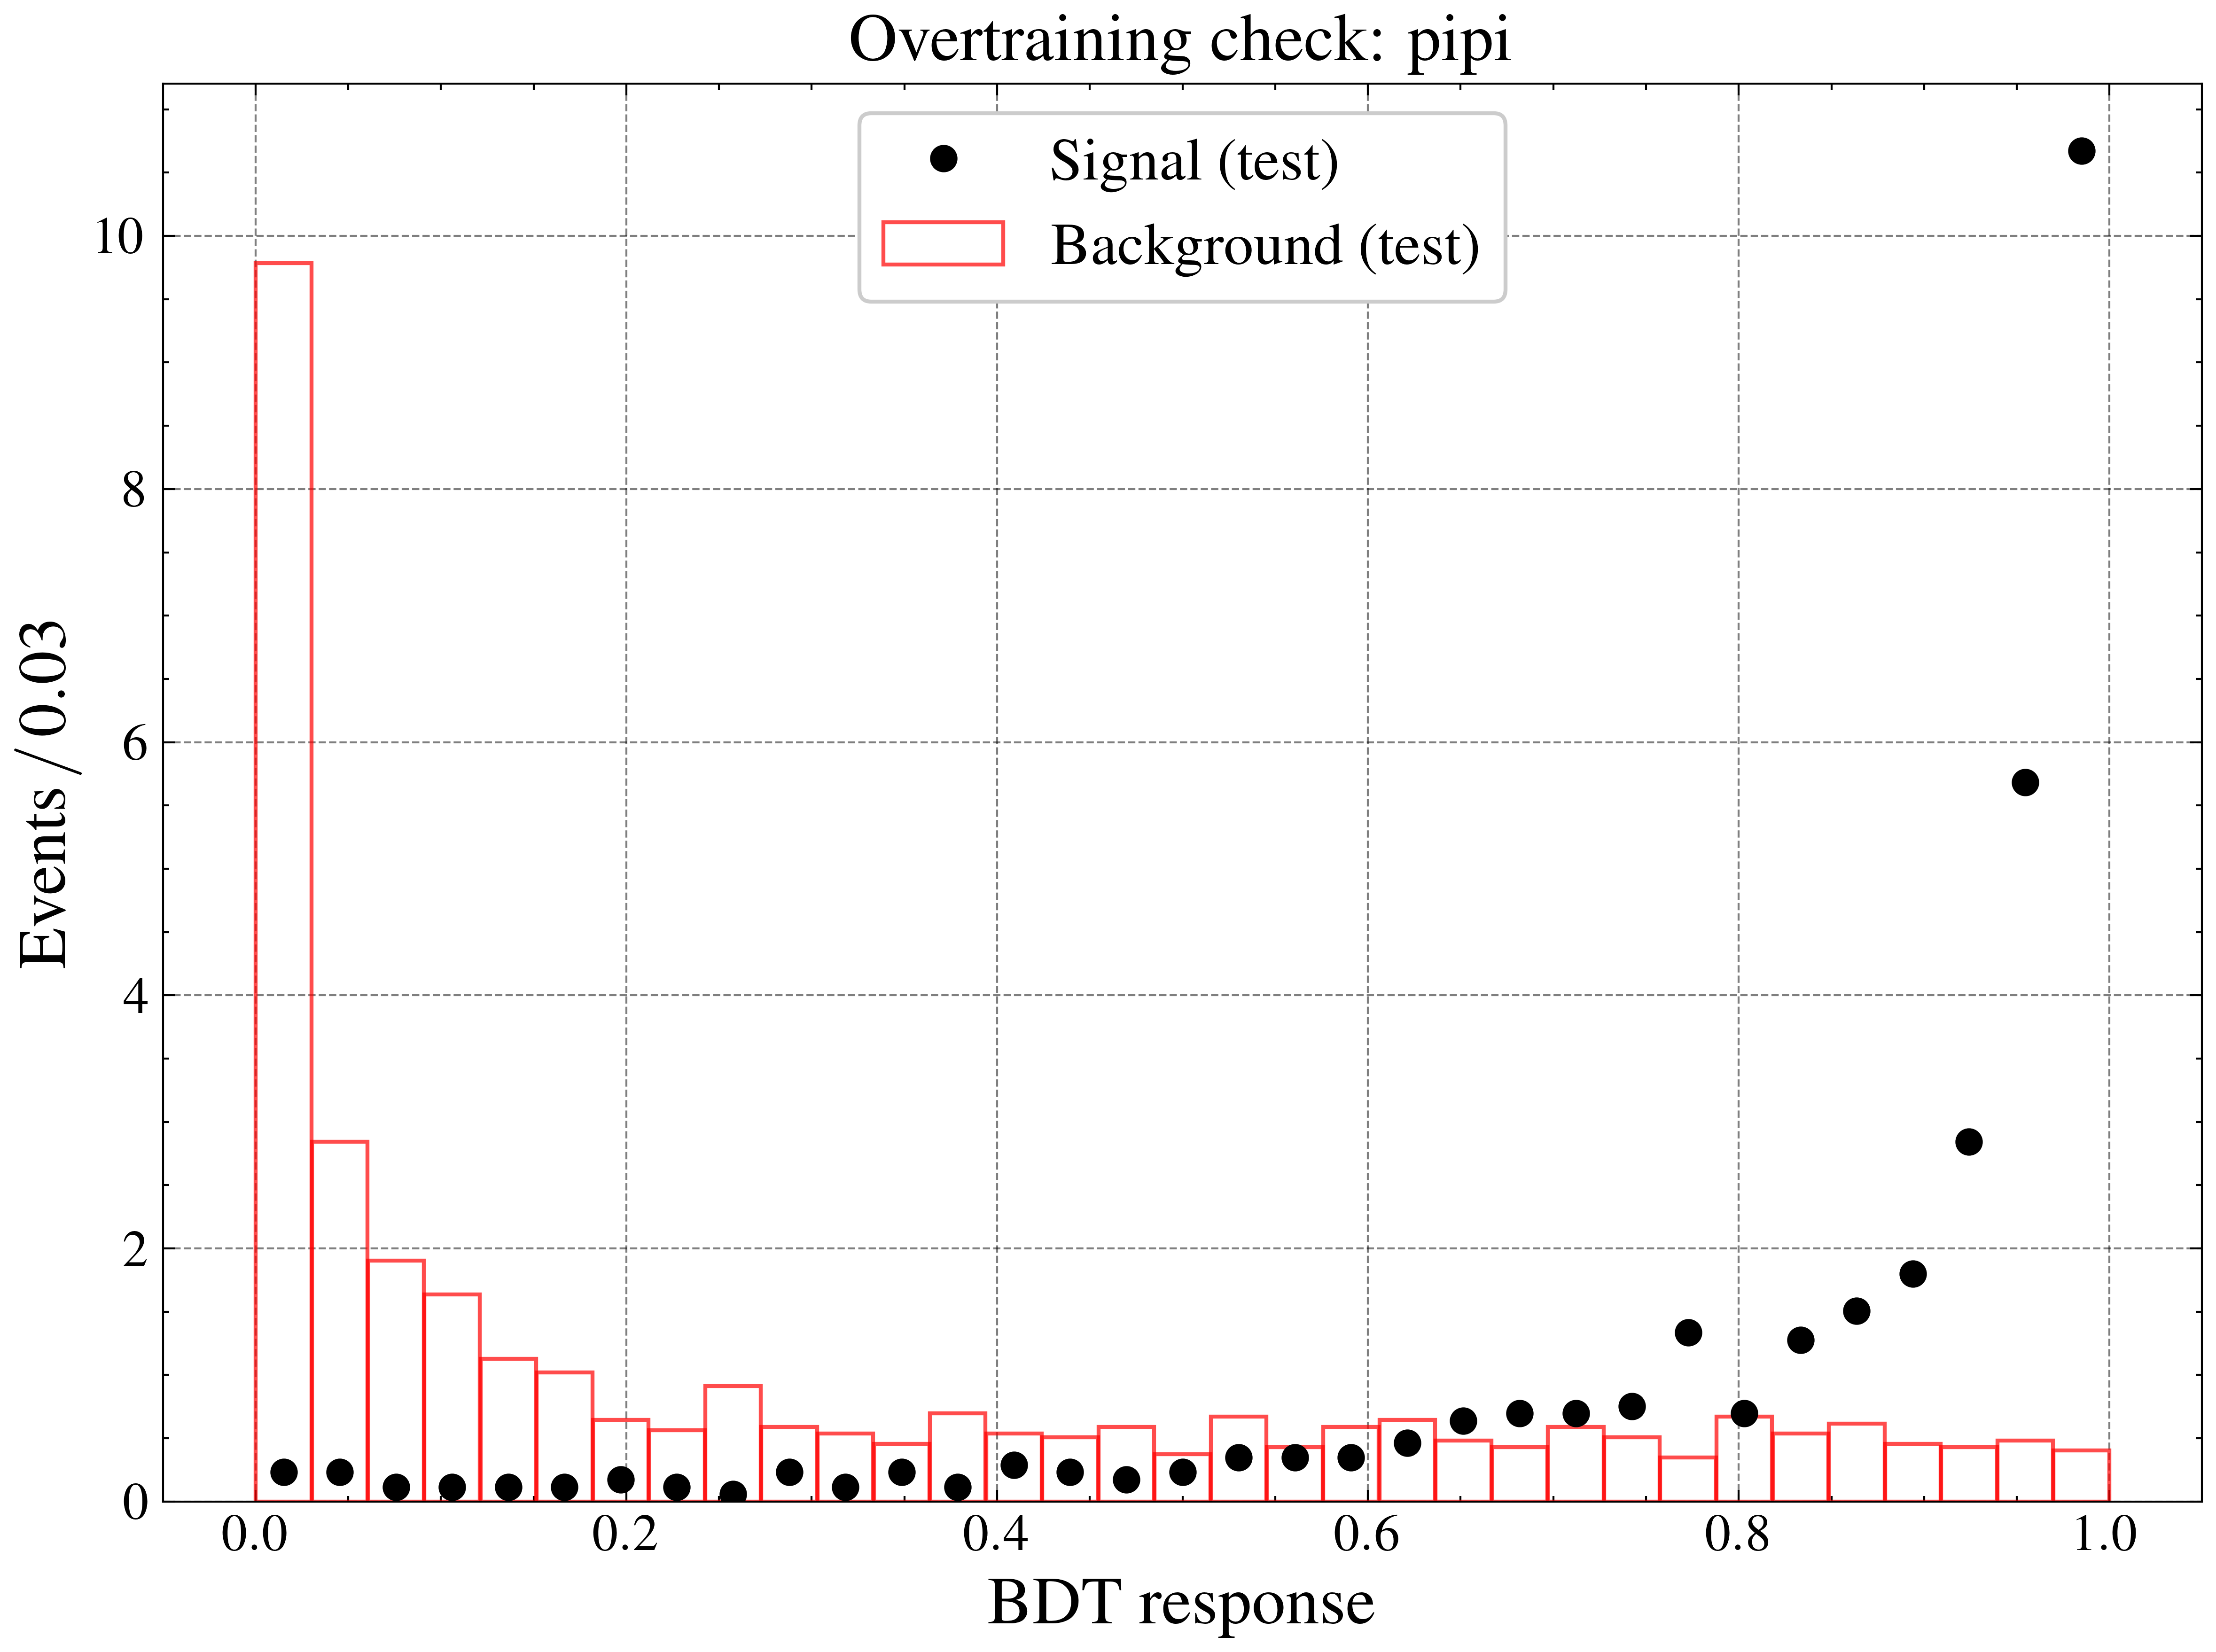

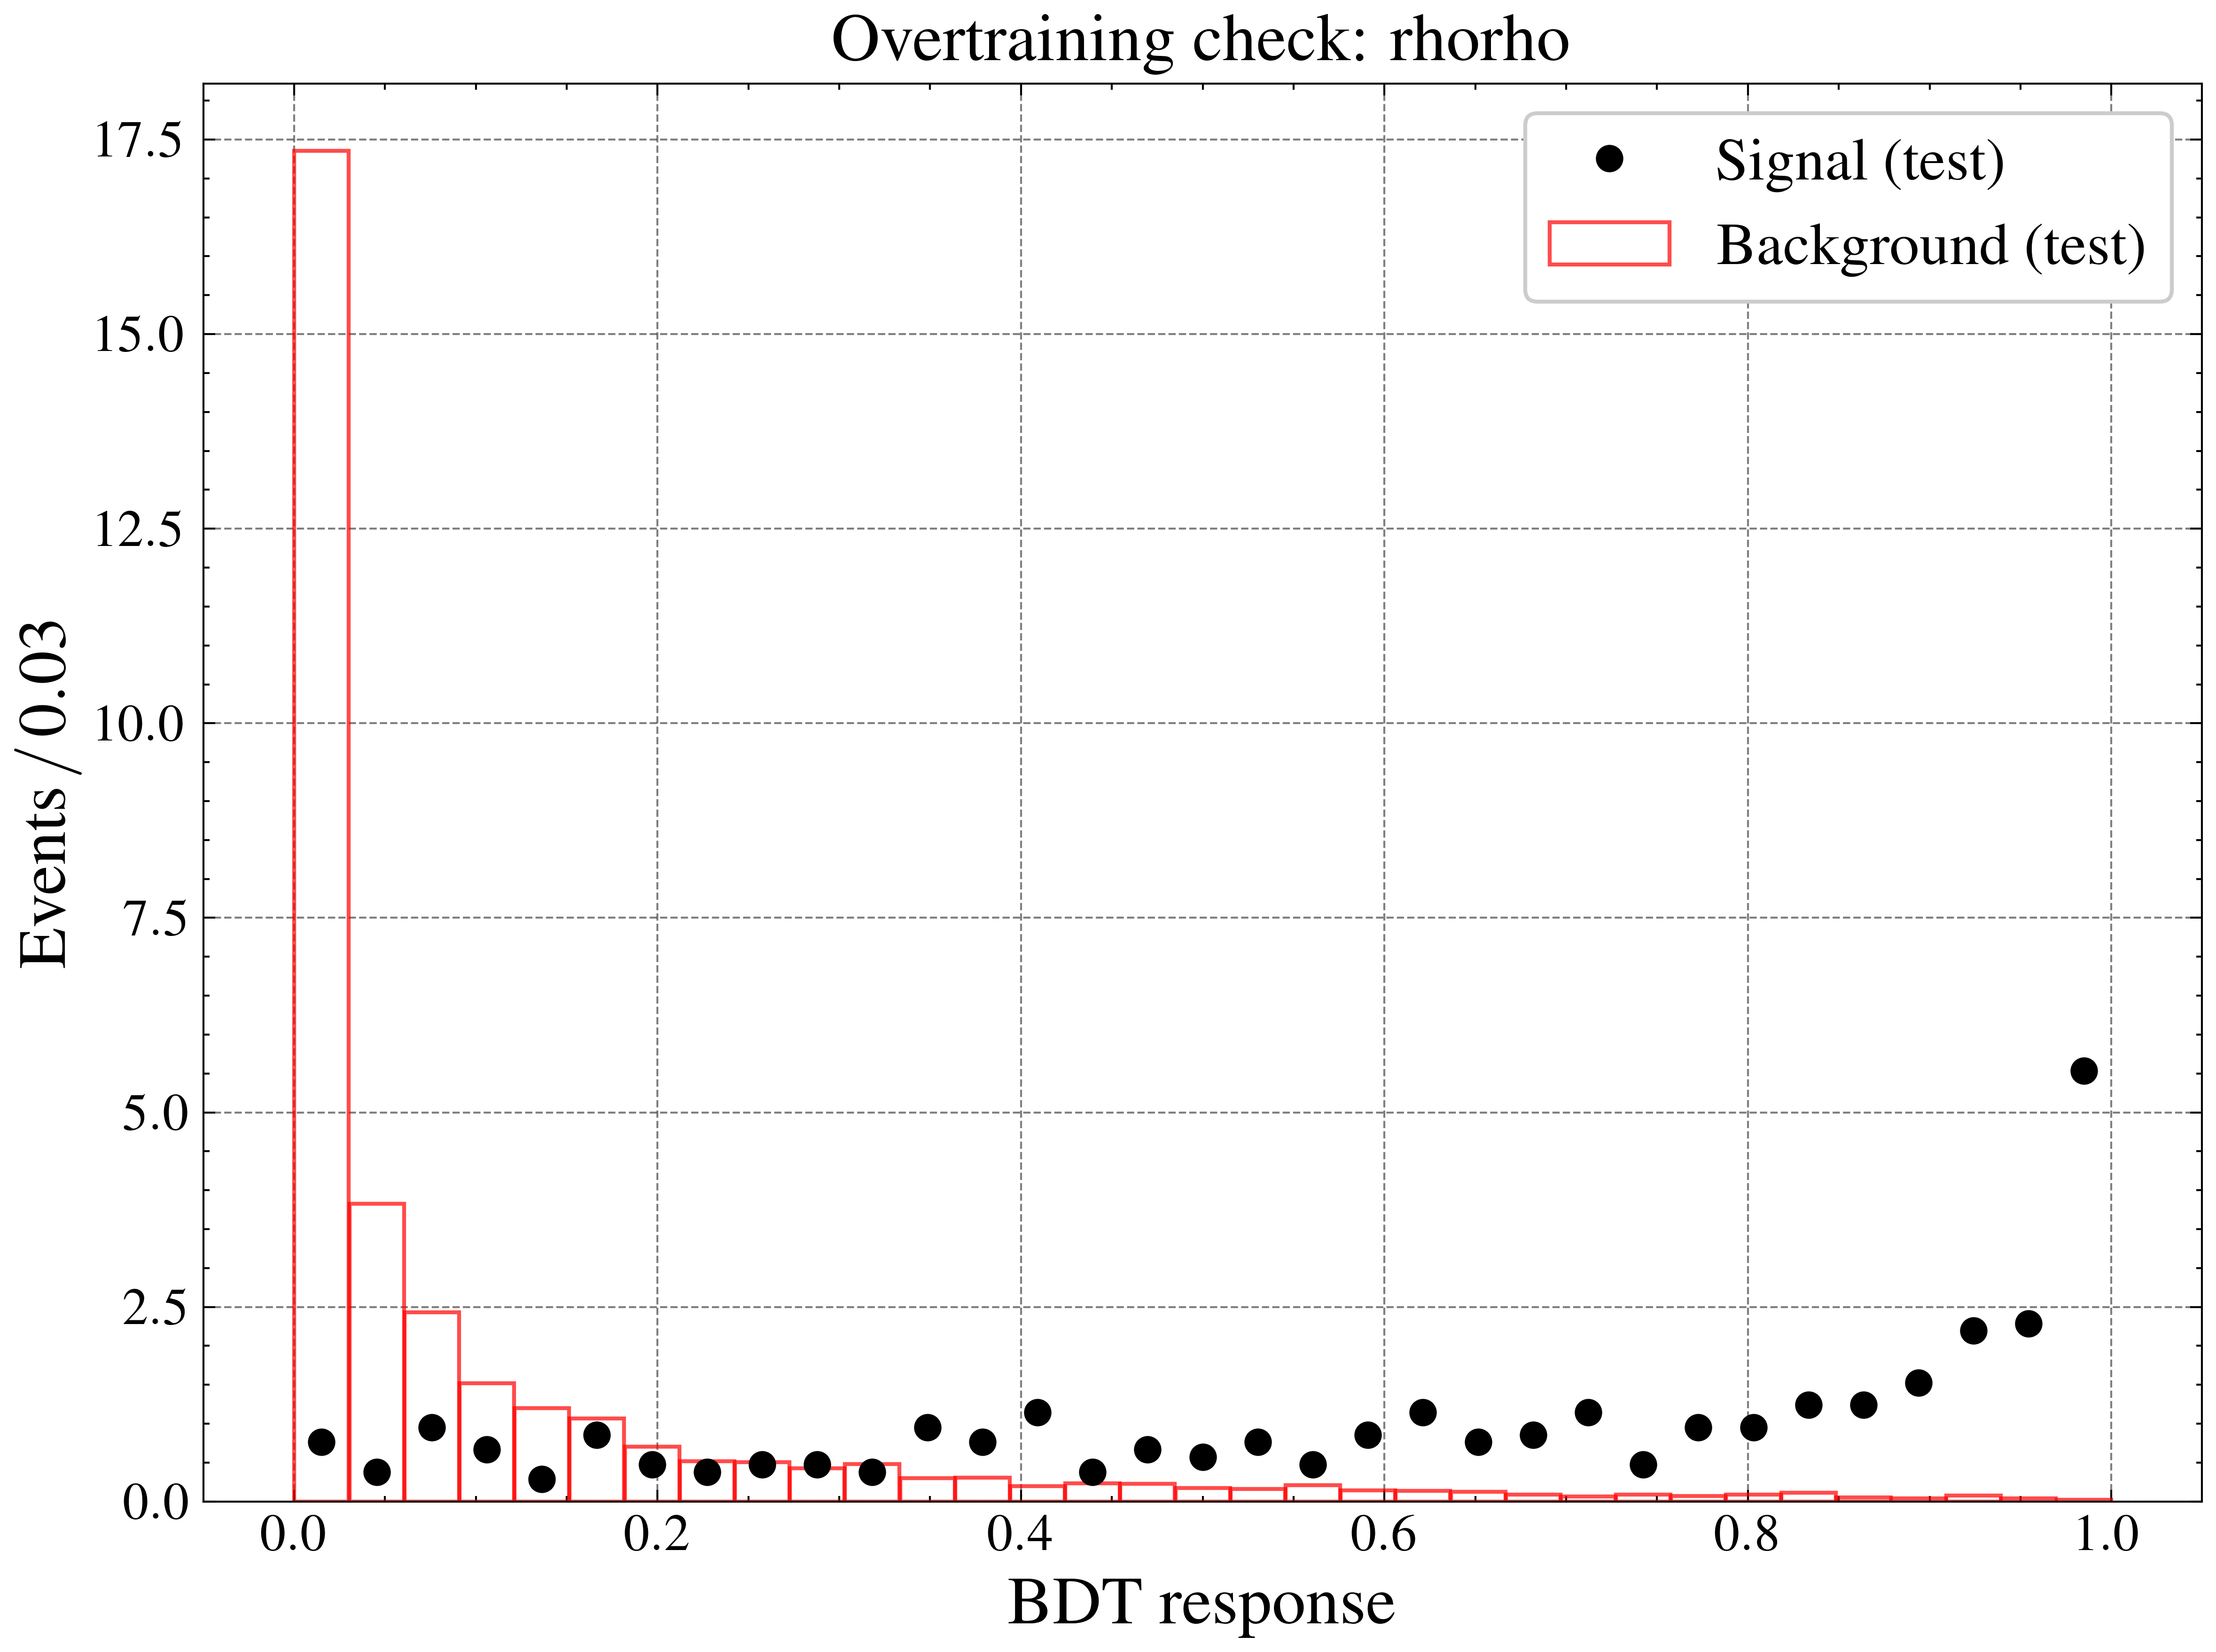

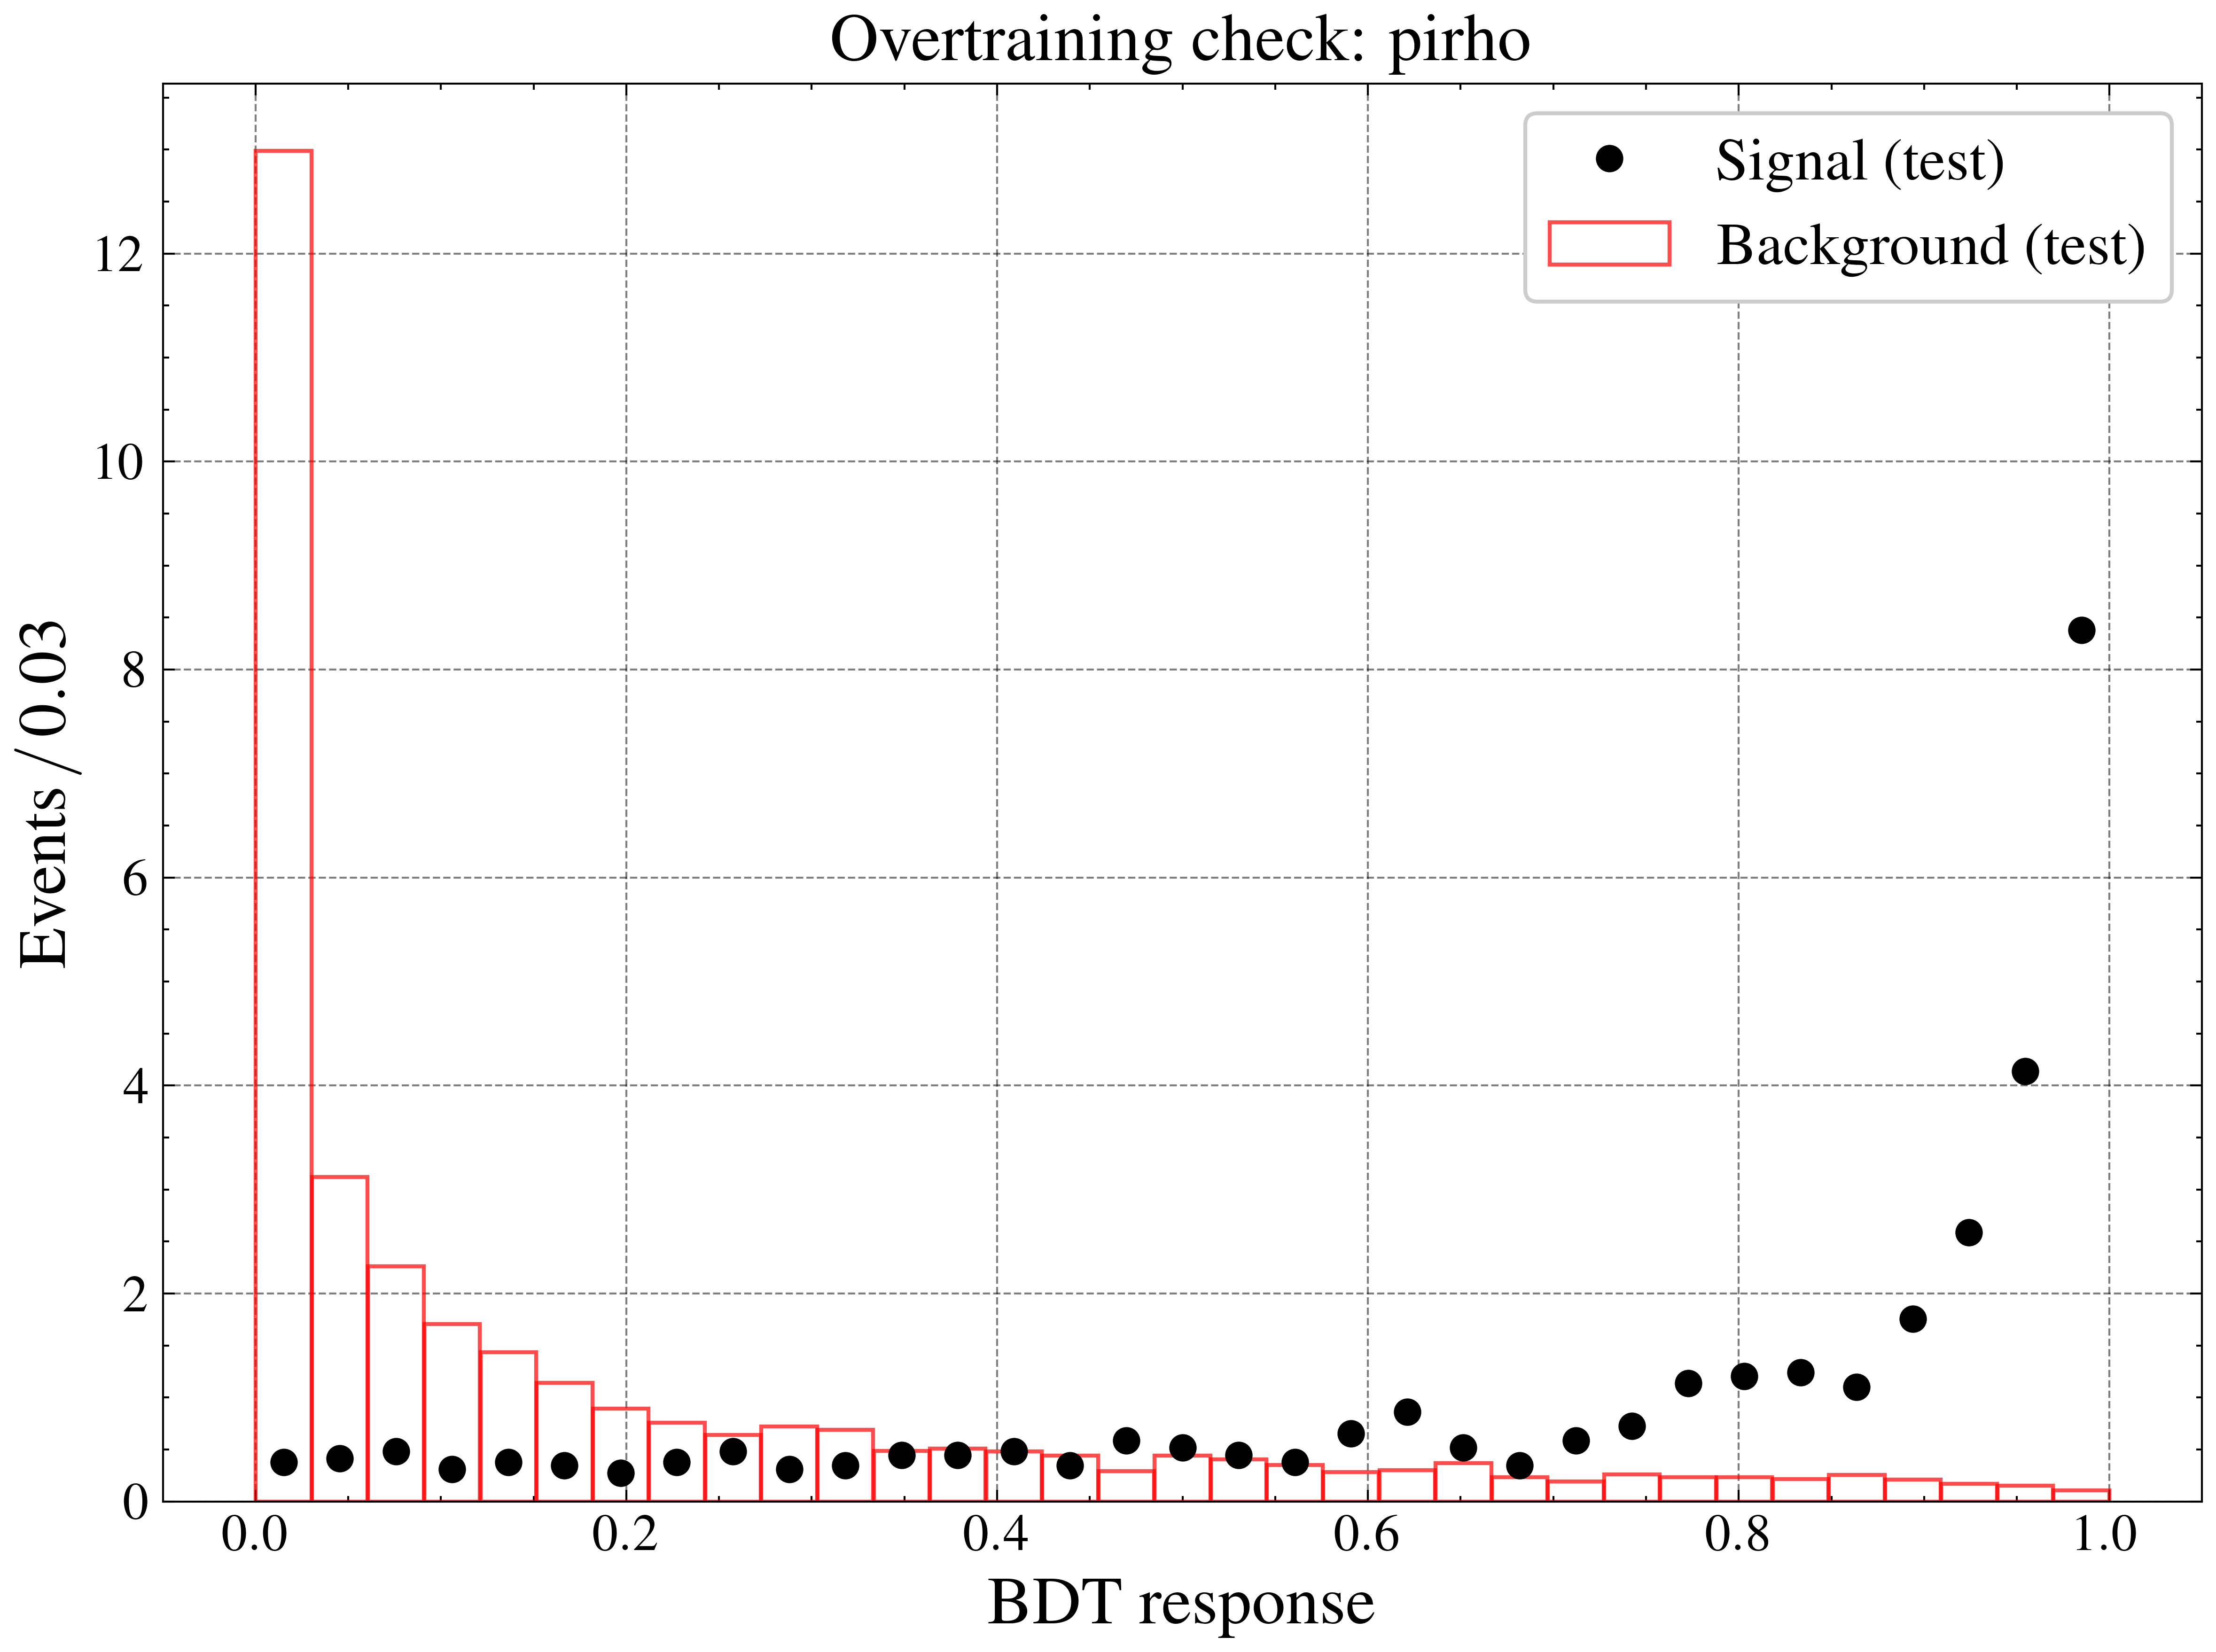

In [11]:
channel_masks = {
    "pipi": mask_pi_pi,
    "rhorho": mask_rho_rho,
    "pirho": mask_pi_rho
}

wbin = 0.03
a = 0
b = 1
bins = np.linspace(a, b, int((b-a)/wbin + 1))

train_pred = model.predict_proba(X_train)[:, 1]
test_pred = model.predict_proba(X_test)[:, 1]

for cname, cmask in channel_masks.items():
    plt.figure(figsize=(8, 6))
    
    # Сигнал и фон для данного канала
    sig_chan = test_pred[(y_test == 1) & cmask]
    bkg_chan = test_pred[(y_test == 0) & cmask]
    counts_sig, _ = np.histogram(sig_chan, bins=bins, density=True)
    errordot(counts_sig, bins=bins, err_func=lambda x: 0, color=colors[0], label="Signal (test)")
    
    counts_bkg, _ = np.histogram(bkg_chan, bins=bins, density=True)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    plt.bar(
        bin_centers, counts_bkg,
        width=wbin, align='center',
        fill=False, alpha=0.7, linewidth=1,
        edgecolor=colors[1], color=colors[1],
        label="Background (test)"
    )
    
    plt.xlabel("BDT response")
    plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}$')
    plt.title(f"Overtraining check: {cname}")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"output/BDT_output_{cname}.pdf", dpi=700)
    plt.show()


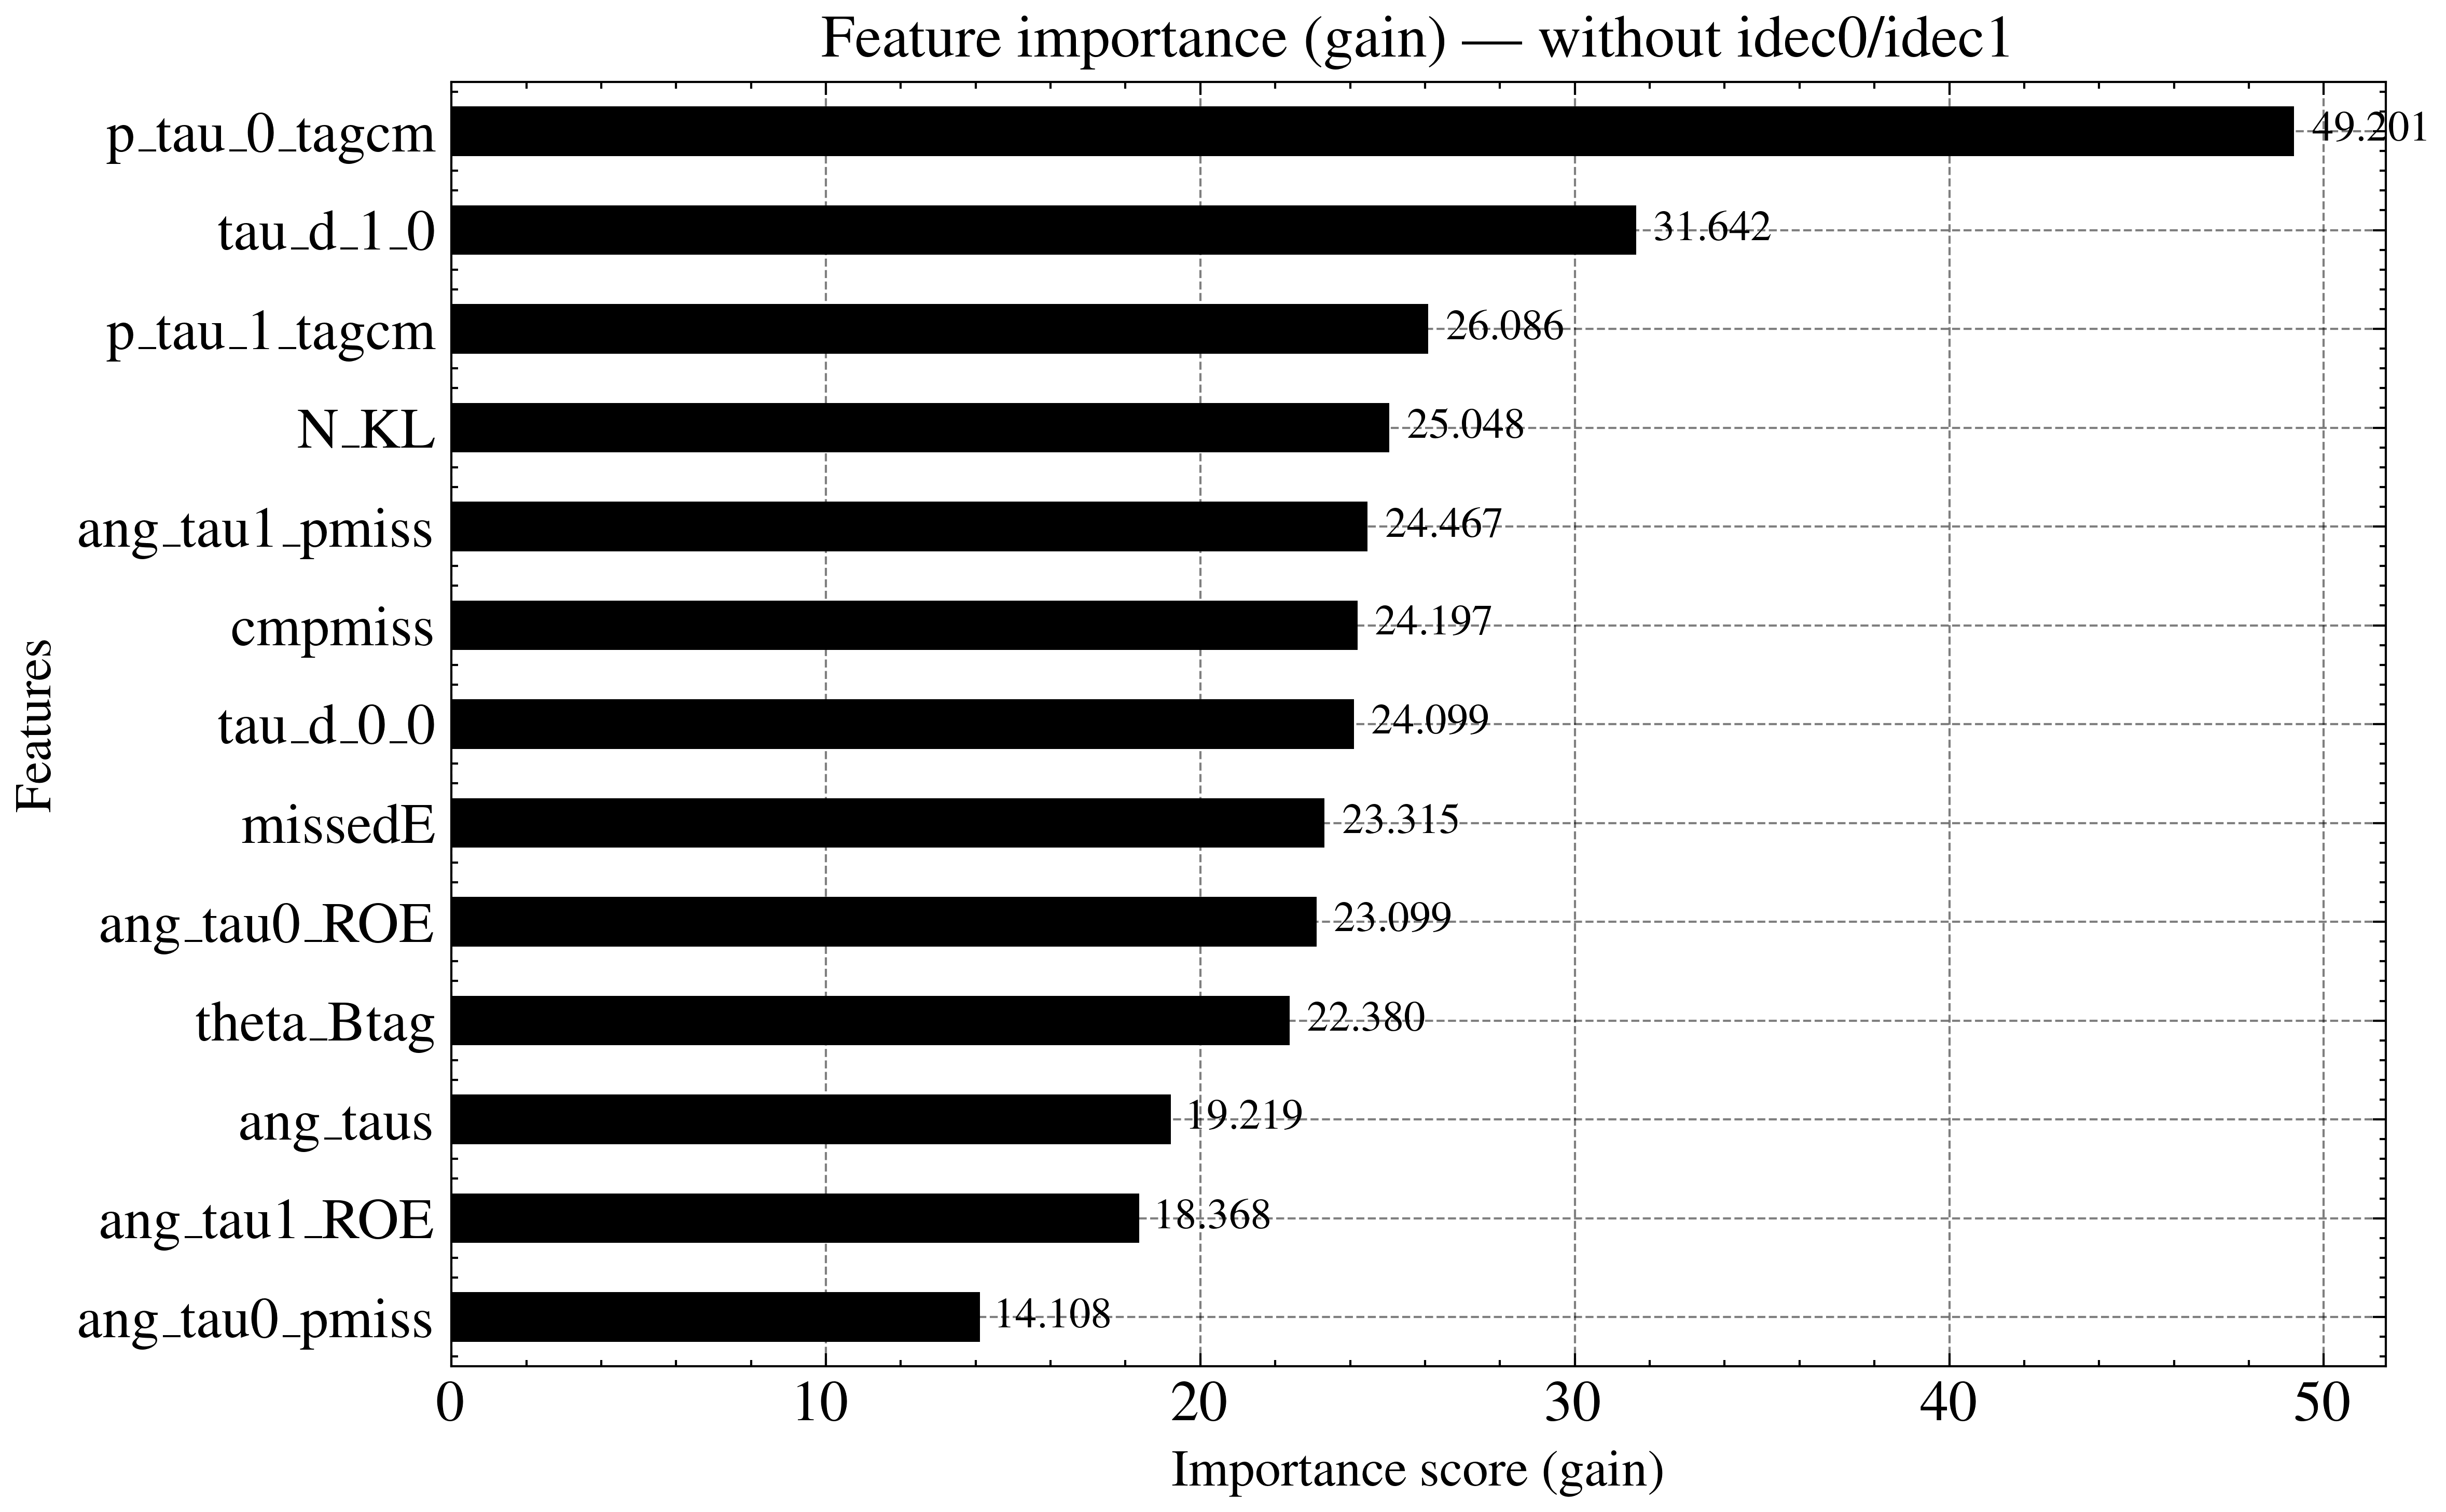

In [12]:
import re
# 1) Получаем booster и "сырые" важности
booster = model.get_booster()

# Варианты: 'gain' | 'weight' | 'cover' | 'total_gain' | 'total_cover'
imp_dict = booster.get_score(importance_type='gain')  # {feat_name: score}

# 2) Сопоставляем имена признаков
# Если вы обучали на DataFrame, booster.feature_names уже должны совпадать с X_train.columns.
# Если видите ключи вида 'f0', 'f1', ... — подменим на реальные имена колонок:
feat_names = list(getattr(model, "feature_names_in_", X_train.columns))
map_fidx_to_name = {f"f{i}": name for i, name in enumerate(feat_names)}

imp_renamed = {}
for k, v in imp_dict.items():
    imp_renamed[map_fidx_to_name.get(k, k)] = v

# 3) Фильтруем idec0/idec1 (и опционально их производные столбцы)
# Базовый строгий фильтр:
drop_exact = {"idec0", "idec1"}

# Если у вас были one-hot или взаимодействия (например, 'idec0_1', 'idec1_0', 'idec0:foo'),
# можно включить и паттерны:
drop_patterns = [r"^idec0(\b|[_:])", r"^idec1(\b|[_:])"]

def keep_feature(name: str) -> bool:
    if name in drop_exact:
        return False
    return not any(re.search(p, name) for p in drop_patterns)

imp_filtered = {k: v for k, v in imp_renamed.items() if keep_feature(k)}

# 4) В pandas.Series и сортировка для barh
if not imp_filtered:
    print("[info] После фильтрации не осталось признаков для отображения.")
else:
    s = pd.Series(imp_filtered).sort_values(ascending=True)

    # 5) Рисуем
    fig, ax = plt.subplots(figsize=(8, 5))
    s.plot(kind='barh', ax=ax)

    # подписи чисел справа от столбиков
    xmax = s.max()
    for i, (feat, val) in enumerate(s.items()):
        ax.text(val + 0.01 * xmax, i, f"{val:.3f}",
                va='center', ha='left', fontsize=10)

    ax.set_title("Feature importance (gain) — without idec0/idec1", fontsize=14)
    ax.set_xlabel("Importance score (gain)", fontsize=12)
    ax.set_ylabel("Features", fontsize=12)
    plt.tight_layout()
    plt.savefig("output/BDT_features_filtered.pdf", dpi=700)
    plt.show()


eff = 0.8471001757469244
Файл 'results/data_pipi.json' обновлён или создан заново.


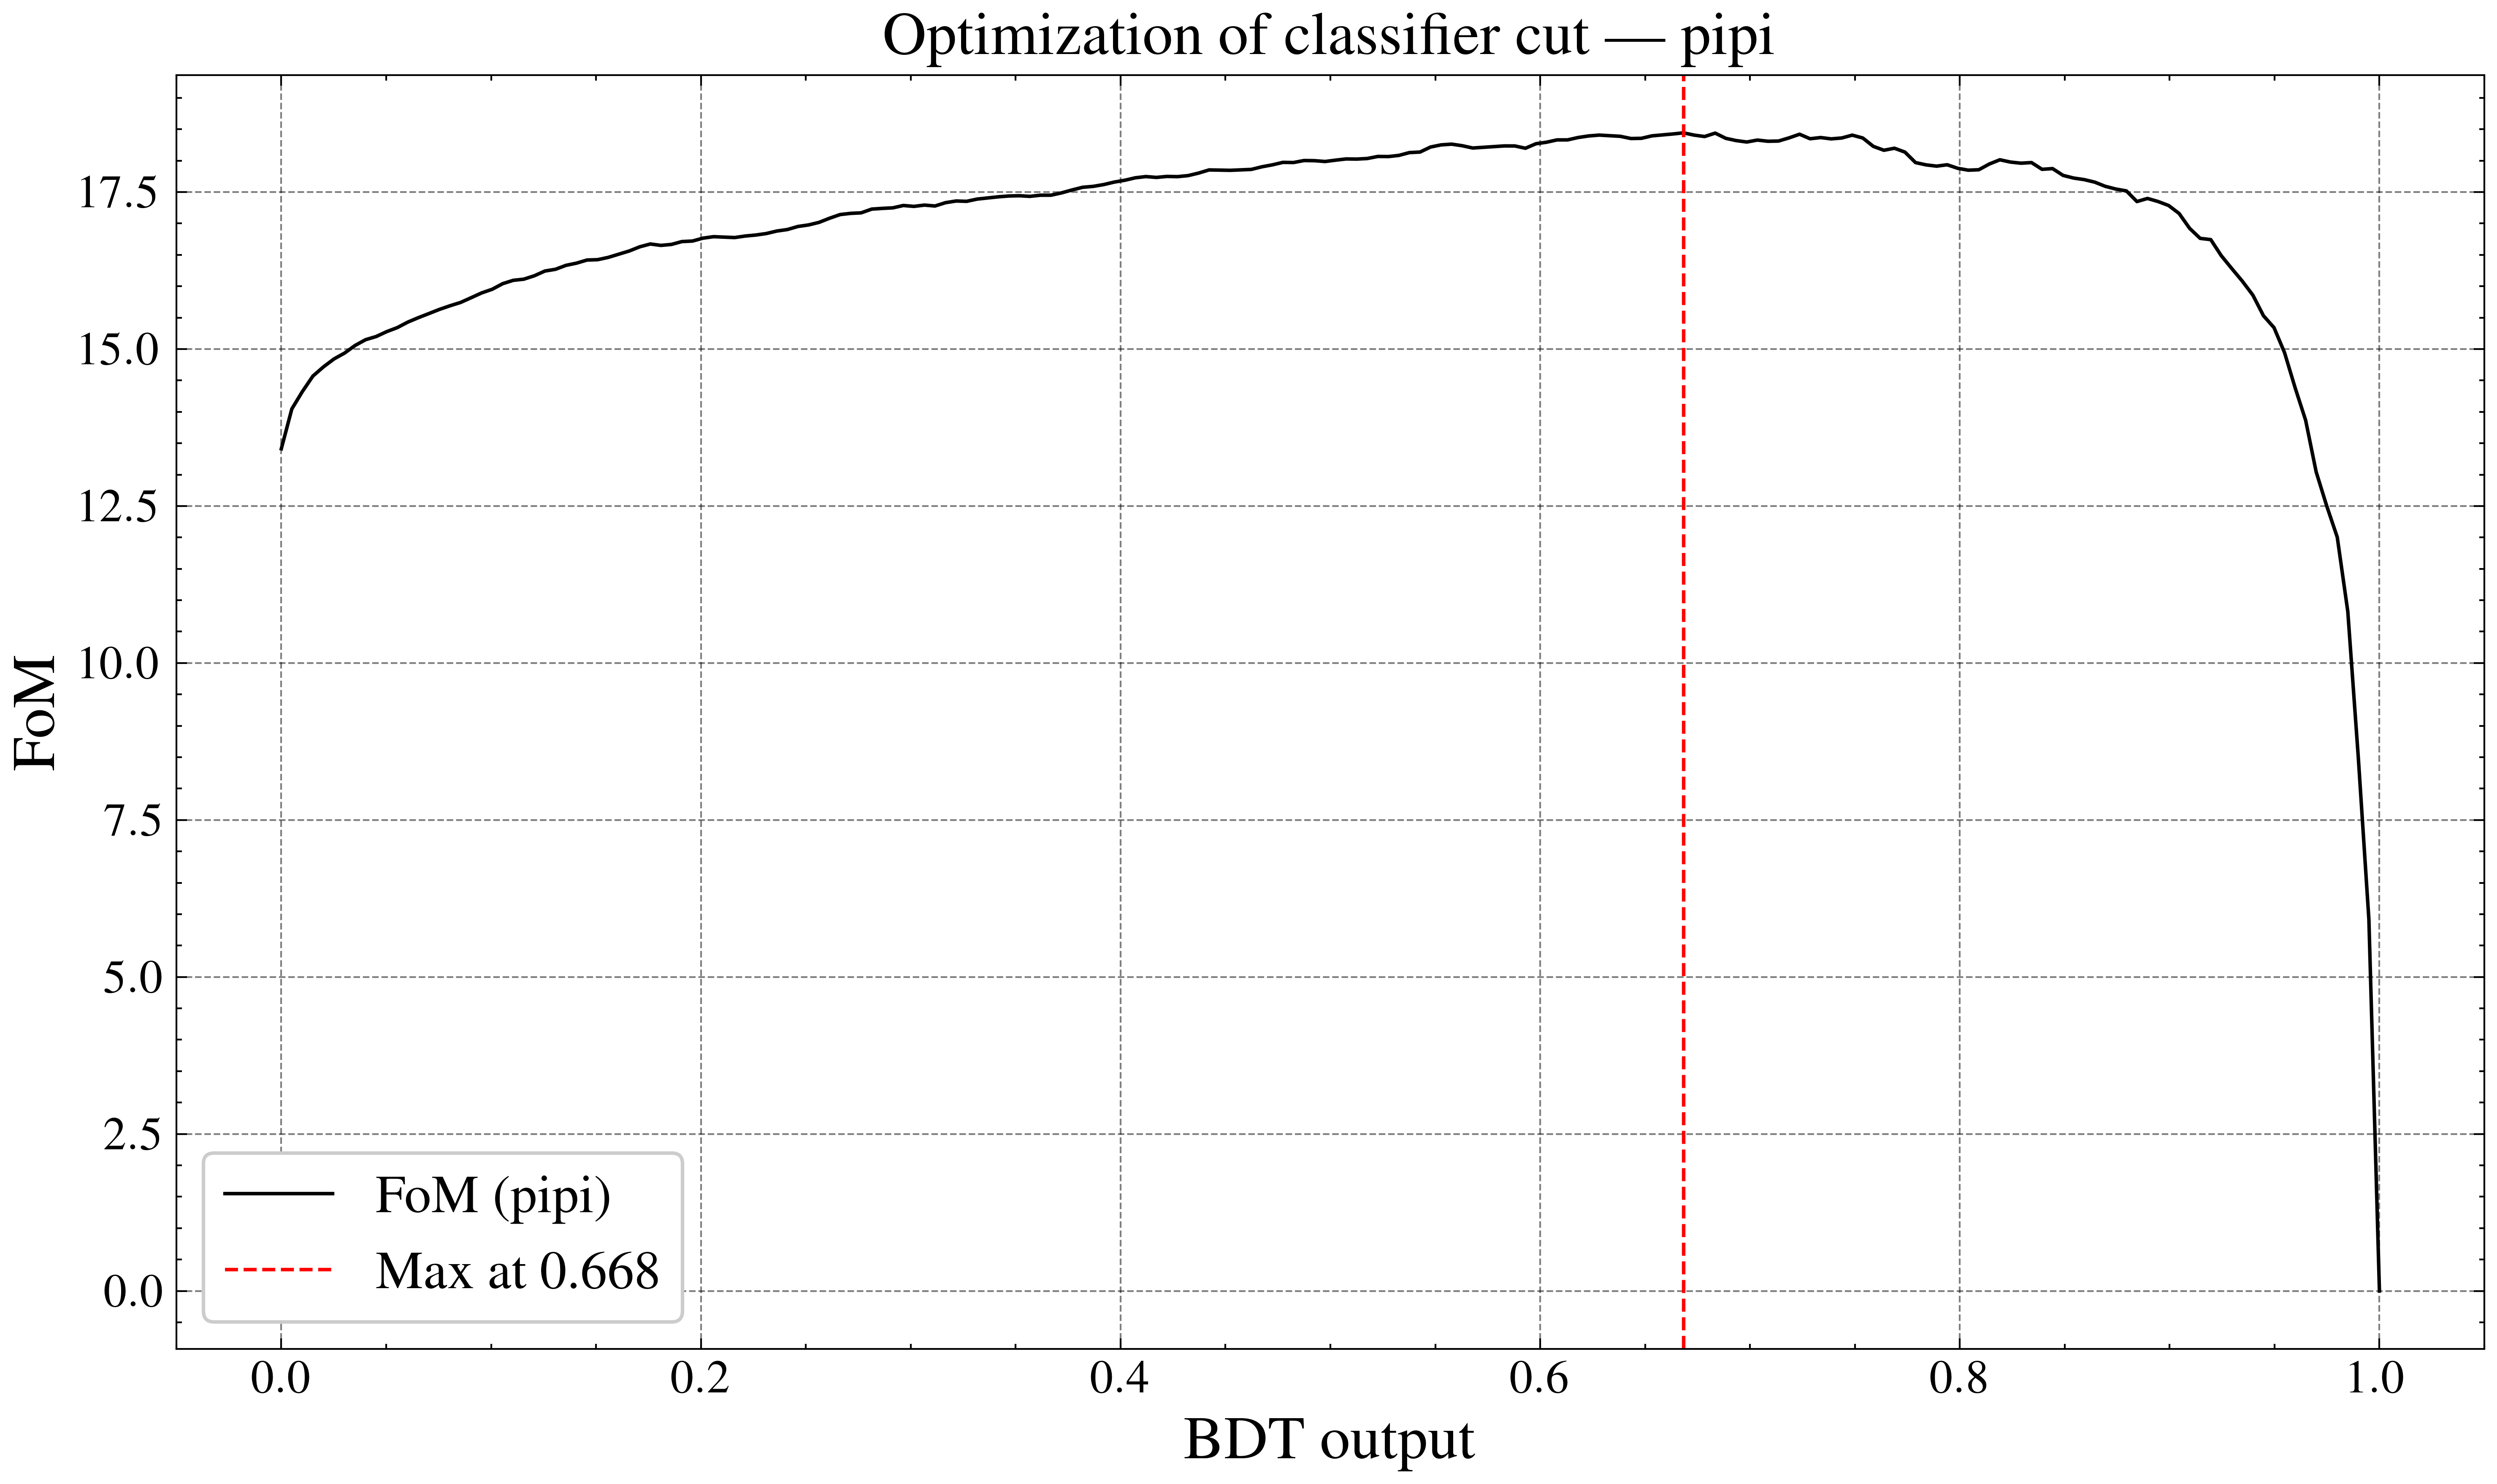

[pipi] Best BDT cut: 0.668, Max FoM = 18.443, Nsig=569, Nbkg=1231
eff = 0.6329479768786127
Файл 'results/data_rhorho.json' обновлён или создан заново.


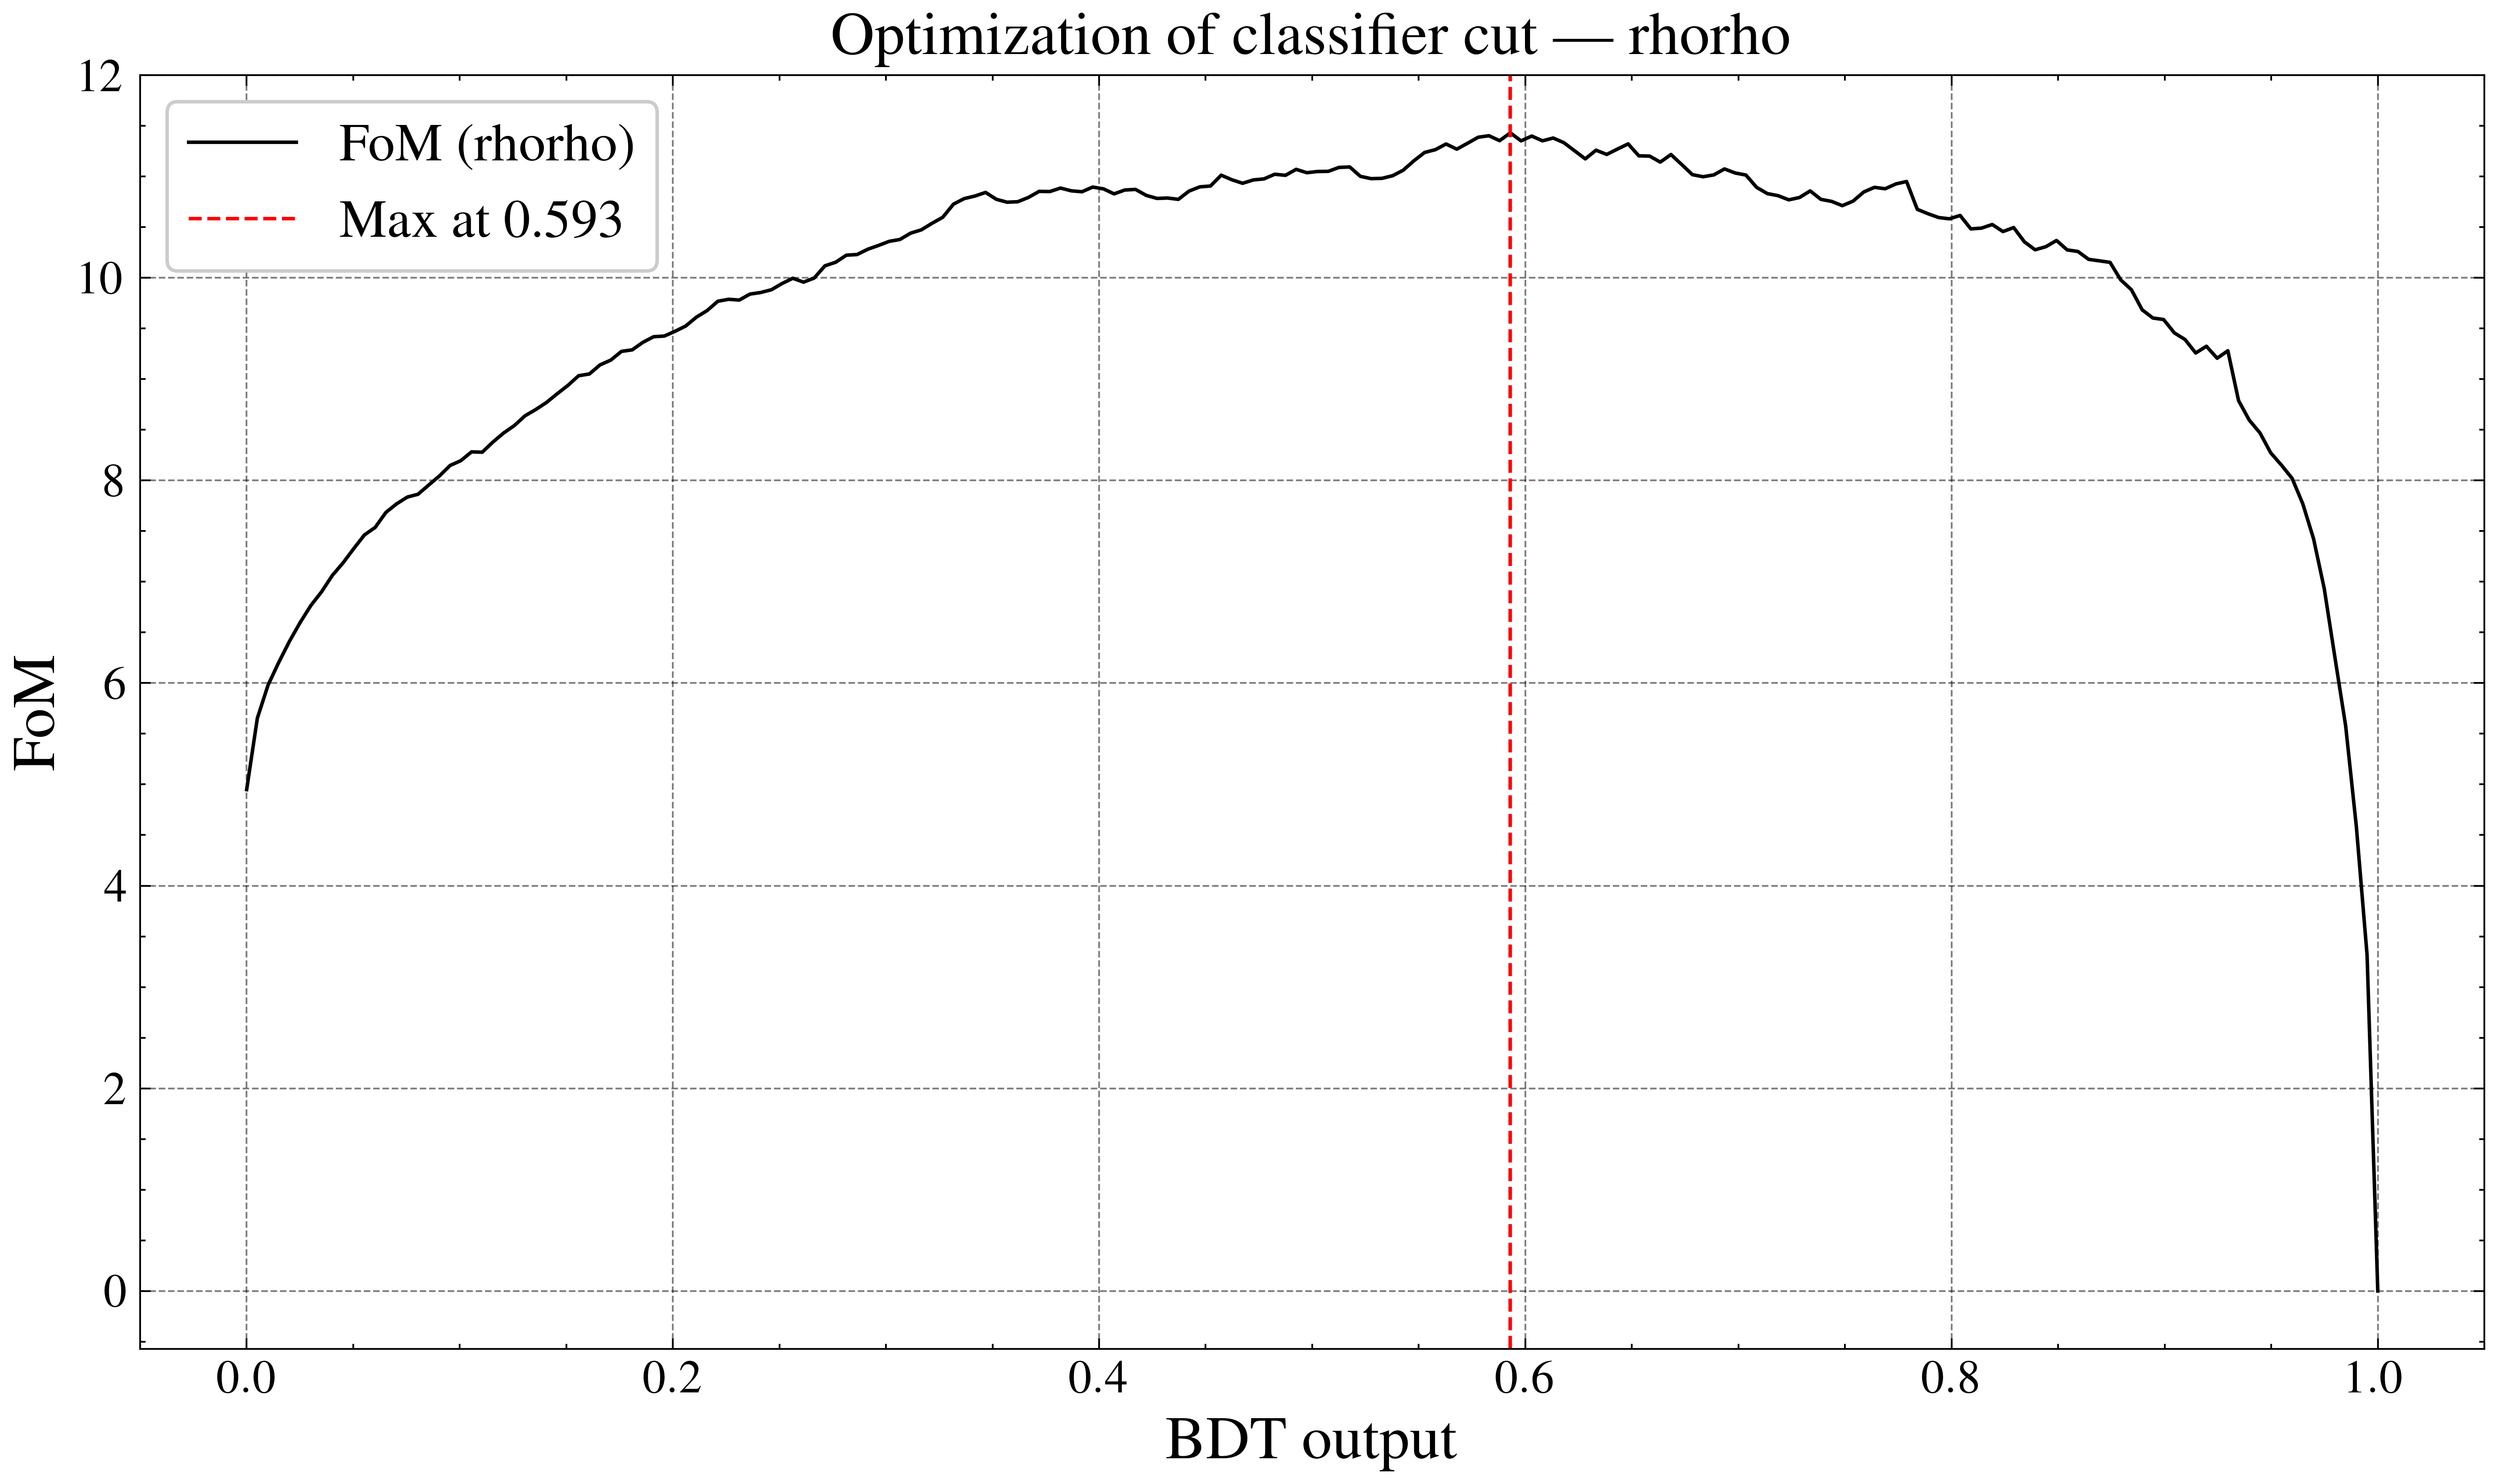

[rhorho] Best BDT cut: 0.593, Max FoM = 11.432, Nsig=346, Nbkg=4543
eff = 0.696969696969697
Файл 'results/data_pirho.json' обновлён или создан заново.


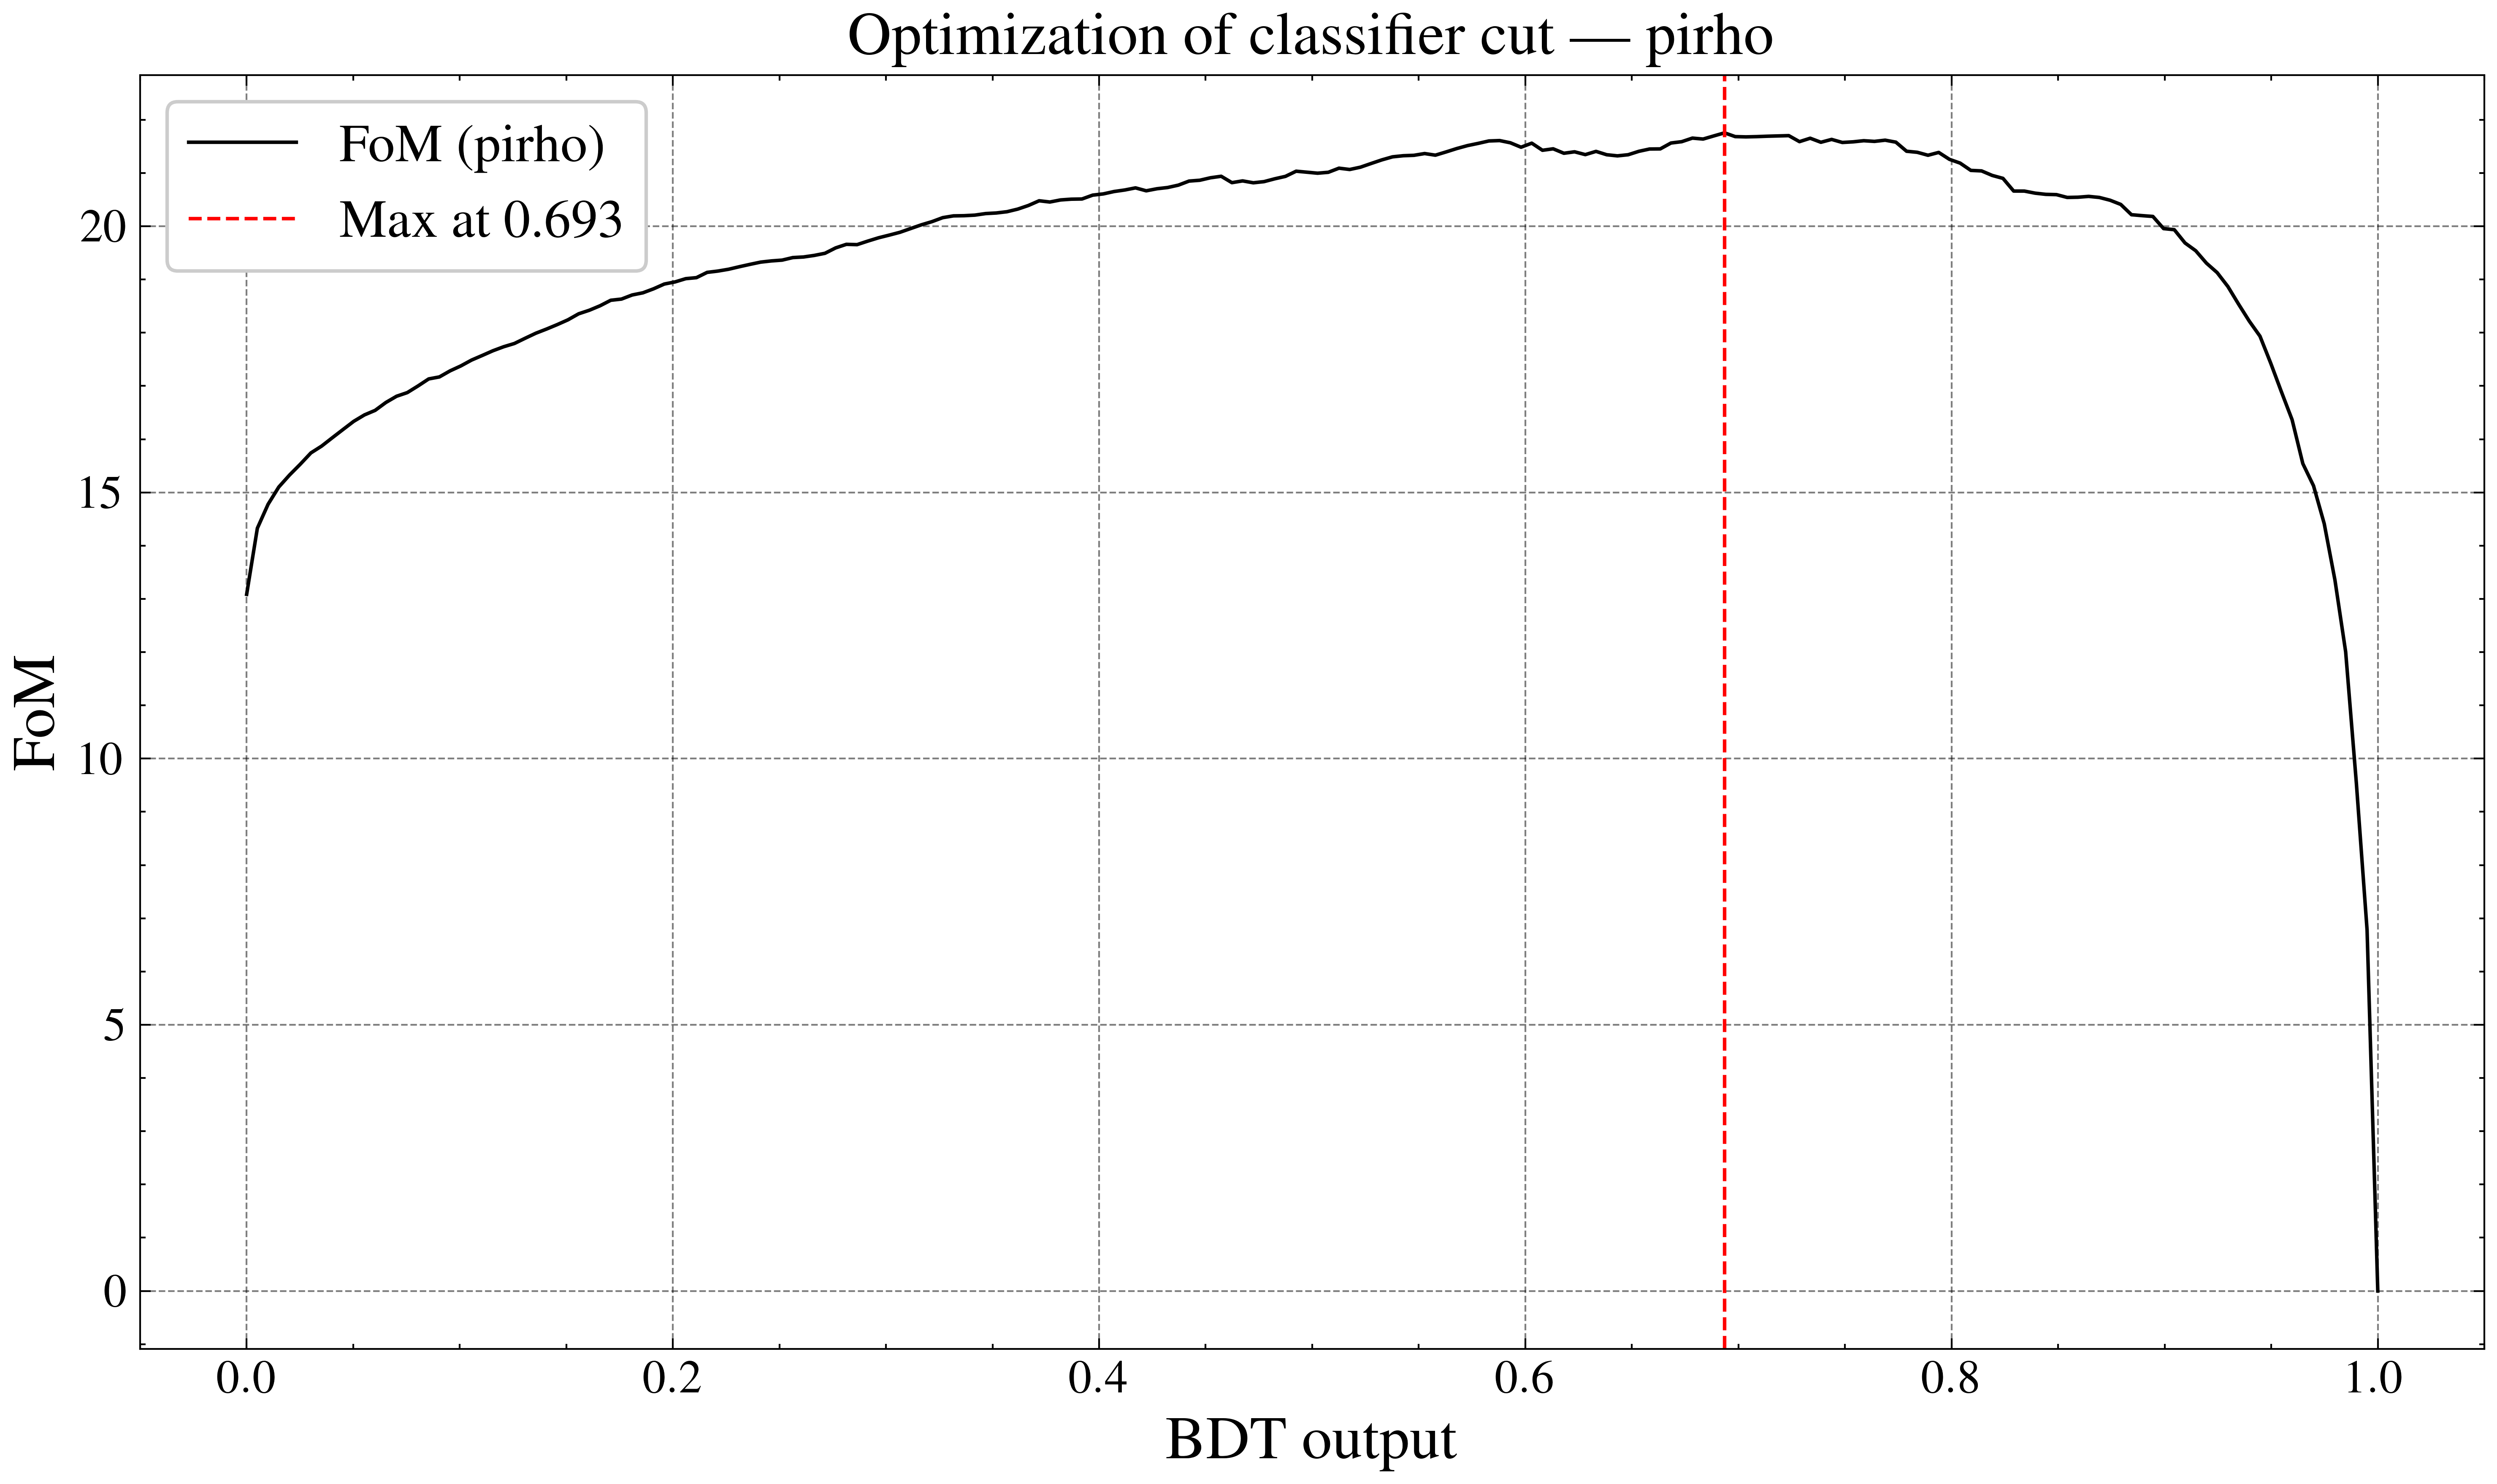

[pirho] Best BDT cut: 0.693, Max FoM = 21.755, Nsig=957, Nbkg=4391


In [13]:
# Предполагается, что:
# - test_pred = model.predict_proba(X_test)[:, 1]
# - channel_masks = {"pi-pi": mask_pi_pi, "rho-rho": mask_rho_rho, "pi-rho": mask_pi_rho}
# - y_test — pandas.Series меток той же выборки (индексы согласованы с X_test)

preds = test_pred
true  = y_test.to_numpy()
FOM_cuts = dict()
# Общая сетка порогов
cuts = np.linspace(0.0, 1.0, 200)

for cname, cmask in channel_masks.items():
    # Канально-специфические маски сигнал/фон
    is_sig_c = (true == 1) & cmask
    is_bkg_c = (true == 0) & cmask

    Nsig_tot = int(np.sum(is_sig_c))
    Nbkg_tot = int(np.sum(is_bkg_c))

    if Nsig_tot == 0 and Nbkg_tot == 0:
        print(f"[{cname}] нет событий в канале — пропуск.")
        continue

    # Веса (замените на реальные, если есть)
    weight_sig = np.ones(np.sum(is_sig_c), dtype=float)
    weight_bkg = np.ones(np.sum(is_bkg_c), dtype=float)


    # Вырезаем предсказания в канале один раз
    preds_sig_c = preds[is_sig_c]
    preds_bkg_c = preds[is_bkg_c]

    FoM  = []
    effS = []
    effB = []

    for cut in cuts:
        S = np.sum(weight_sig[preds_sig_c > cut])
        B = np.sum(weight_bkg[preds_bkg_c > cut])

        fom = S / np.sqrt(S + B + 1e-6)  # численная устойчивость
        FoM.append(fom)
        effS.append(S / max(1, Nsig_tot))
        effB.append(B / max(1, Nbkg_tot))

    FoM  = np.array(FoM)
    effS = np.array(effS)
    effB = np.array(effB)

    imax = int(np.argmax(FoM))
    best_cut = float(cuts[imax])
    print(f"eff = {np.sum(weight_sig[preds[is_sig_c] > best_cut])/np.sum(weight_sig[preds[is_sig_c] > 0])}")
    json_update(f"results/data_{cname}.json", {"BDT_eff": float(np.sum(weight_sig[preds[is_sig_c] > best_cut])/np.sum(weight_sig[preds[is_sig_c] > 0])),})
    FOM_cuts[cname] = np.sum(weight_sig[preds[is_sig_c] > best_cut])/np.sum(weight_sig[preds[is_sig_c] > 0])
    # Рисунок для данного канала
    plt.figure(figsize=(10, 6))
    plt.plot(cuts, FoM, label=f'FoM ({cname})')
    plt.axvline(best_cut, color='r', linestyle='--', label=f'Max at {best_cut:.3f}')
    plt.xlabel("BDT output")
    plt.ylabel("FoM")
    plt.title(f"Optimization of classifier cut — {cname}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"output/BDT_FoM_{cname}.pdf", dpi=700)
    plt.show()

    print(f"[{cname}] Best BDT cut: {best_cut:.3f}, Max FoM = {FoM[imax]:.3f}, "
          f"Nsig={Nsig_tot}, Nbkg={Nbkg_tot}")


In [14]:
model.save_model("models/bdt_model_pirho.json")

In [15]:
list(sig.columns)

['cmpmiss',
 'missedE',
 'ang_taus',
 'ang_tau0_pmiss',
 'ang_tau1_pmiss',
 'p_tau_0_tagcm',
 'p_tau_1_tagcm',
 'theta_Btag',
 'tau_d_0_0',
 'tau_d_1_0',
 'N_KL',
 'ang_tau1_ROE',
 'ang_tau0_ROE',
 'idec0',
 'idec1',
 'label']

In [16]:
list(sig.columns).remove

<function list.remove(value, /)>

In [17]:
import json

# Сохраняем имена колонок и значения FoM в json
data_to_save = {
    "columns": list(sig.columns)[:-1],
    "FoM": FOM_cuts
}

with open("models/columns_and_fom_pirho.json", "w") as f:
    json.dump(data_to_save, f, indent=4)

In [18]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model("models/bdt_model_pirho.json")
with open("models/columns_and_fom_pirho.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [19]:
FoM

{'pipi': 0.8471001757469244,
 'rhorho': 0.6329479768786127,
 'pirho': 0.696969696969697}